In [12]:
import SimpleITK as sitk
import numpy as np
import csv
import os
from PIL import Image
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
%matplotlib inline

In [9]:
# Functions for loading data and converting coordinate systems

def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
    return dict(data=numpyImage, origin=numpyOrigin, spacing=numpySpacing)

def readCSV(filename):
    lines = []
    with open(filename, "r") as f:
        csvreader = csv.reader(f)
        for line in csvreader:
            lines.append(line)
    return lines

def worldToVoxelCoord(worldCoord, origin, spacing):
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return voxelCoord

def normalizePlanes(npzarray):
    maxHU = 400.
    minHU = -1000.
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

### Get relevant file paths

In [3]:
cand_path = './BigData/CSVFILES/annotations.csv'

In [6]:
images_dir = './BigData/subset4'
images_paths = glob.glob(images_dir+'/*.mhd')
len(images_paths)

89

### Investigate pixel spacing differenecs

In [17]:
spacings = np.empty((len(images_paths), 3))

for i,path in enumerate(tqdm(images_paths)):
    image = load_itk_image(path)
    spacings[i] = image['spacing']

100%|██████████| 89/89 [00:24<00:00,  3.64it/s]


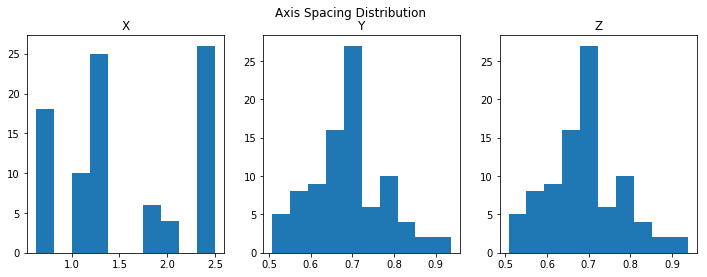

In [33]:
fig = plt.figure(figsize=(12,4))
tits = ['X','Y','Z']
for i in range(3):
    fig.add_subplot(130+i+1)
    plt.hist(spacings[:,i]);
    plt.title(tits[i])
    
fig.suptitle('Axis Spacing Distribution');

### Read a sample Image

In [10]:
img0 = load_itk_image(images_paths[0])
type(img0)

dict

In [34]:
img0['data'].shape

(471, 512, 512)

In [35]:
img0['data'].min(), img0['data'].max()

(-3024, 3072)

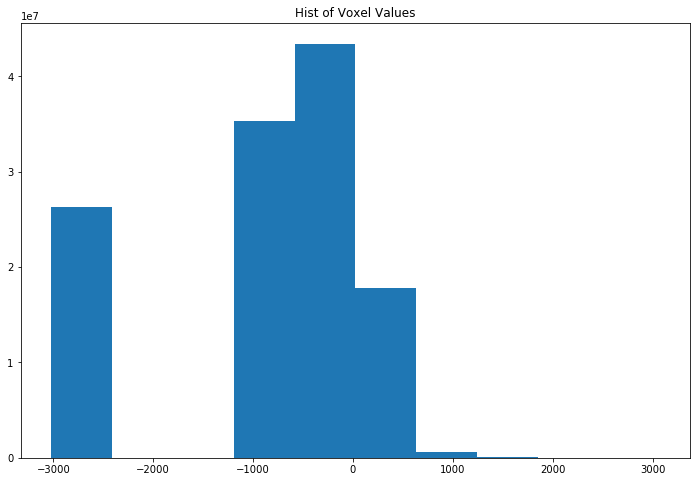

In [38]:
fig = plt.figure(figsize=(12,8))
plt.hist(img0['data'].ravel())
plt.title('Hist of Voxel Values');

### Images need to be clipped and normalized

Data is in Hounsfield Units.

< -1000 is outside the scanning bounds

-1000 is Air

0 is Water

700+ is Bone

In [39]:
def clip_and_normalize(data):
    '''
    Clips data taken as HU so that all points are between Air and Bone inclusive.
    Normalizes the clipped data to between 0 and 1.
    '''
    clipped = np.clip(data, a_min=-1000, a_max=700)
    normd = (clipped + 1000) / 1700
    return np.clip(normd, a_min=0, a_max=1)

### Check Results

In [40]:
img0_n = clip_and_normalize(img0['data'])

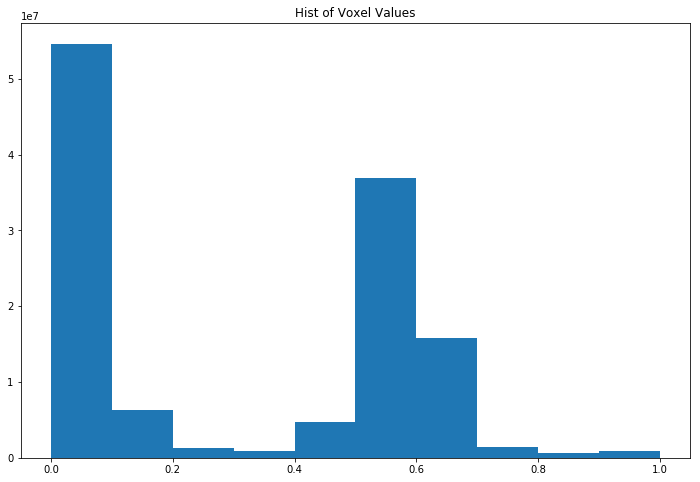

In [41]:
fig = plt.figure(figsize=(12,8))
plt.hist(img0_n.ravel())
plt.title('Hist of Voxel Values');

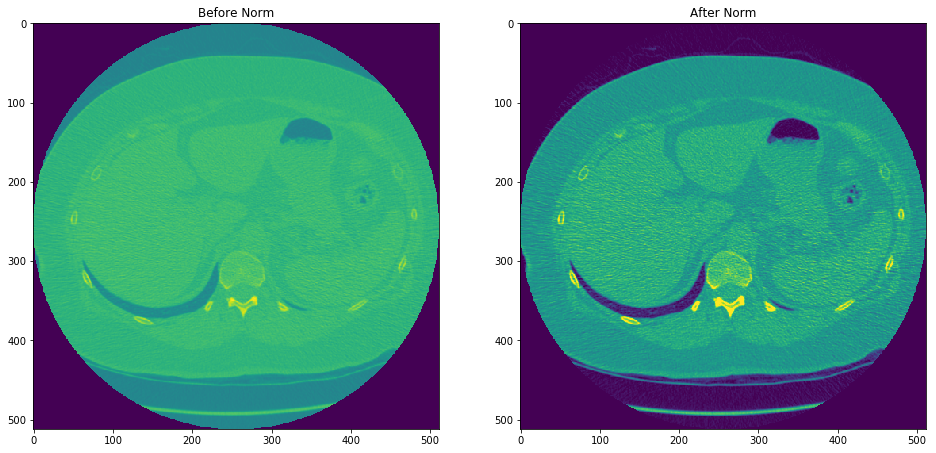

In [47]:
fig = plt.figure(figsize=(16,8))
fig.add_subplot(121)
plt.imshow(img0['data'][42])
plt.title('Before Norm')
fig.add_subplot(122)
plt.imshow(img0_n[42])
plt.title('After Norm');